In [36]:
import numpy as np
import matplotlib.pyplot as plt
from lds import *
from generate_valid_env import generate_centered_stable_weights
from environment import Environment
from ucb_agents import StationaryAgent, LatentARLinUCB, KalmanFilterAgent
from simulations import calculate_ground_truth, run_simulation

In [76]:
def create_env_params(k, sigma_z, sigma_r):
    gammas = [0.9] if k == 1 else generate_centered_stable_weights(k, 2, 123)
    env_params = dict(gamma_0=0,
            mu_a=[0, 0],
            beta_a=[-1.0, 1.0],
            sigma_z=sigma_z,
            sigma_r=sigma_r,
            K=k,
            gammas=gammas,
            init_zs=np.zeros(k)
            )
#     np.random.seed(2024)
#     env_params['init_zs'] = 10 * np.random.randn(env_params['K'])

    return env_params

In [77]:
def compute_bias_term(k, beta_a, Gamma, K, s, z_s_tilde):
    c_a = compute_c_a(k, beta_a)
    C = compute_C(k)
    A = Gamma - Gamma @ K @ C
    A_s = np.linalg.matrix_power(A, s)

    return c_a @ A_s @ z_s_tilde

def g_a_j(j, c_a, Gamma, K, C):
    A = Gamma - Gamma @ K @ C
    return c_a.T @ np.linalg.matrix_power(A, j) @ Gamma @ K

def construct_beta_and_mu_tilde(s, betas, mus, c_a, num_actions, Gamma, K, C):
    beta_tilde = []
    mu_tilde = []
    for i in range(s):
        curr_g_a = g_a_j(i, c_a, Gamma, K, C)
        beta_tilde = [curr_g_a / betas[a] for a in range(num_actions)] + beta_tilde
        mu_tilde = [mus[a] * curr_g_a / betas[a] for a in range(num_actions)] + mu_tilde

    return np.array(beta_tilde).flatten(), np.array(mu_tilde).flatten()

def get_true_theta(s, a, env_params):
    mus = env_params["mu_a"]
    betas = env_params["beta_a"]
    gammas = env_params["gammas"]
    gamma_0 = env_params["gamma_0"]
    k = env_params["K"]
    sigma_z = env_params["sigma_z"]
    sigma_r = env_params["sigma_r"]
    num_actions = len(mus)
    Gamma, C, W, V, mu_z = create_lds_from_ar_process(gammas, gamma_0, k, sigma_z, sigma_r, betas)
    P = compute_P(Gamma, C, W, V)
    Kalman_Gain = compute_K(P, C, V)
    c_a = compute_c_a(k, betas[a])
    beta_tilde, mu_tilde = construct_beta_and_mu_tilde(s, betas, mus, c_a, num_actions, Gamma, Kalman_Gain, C)
    mu_a = mus[a]

    return np.concatenate((beta_tilde, mu_tilde, [mu_a]))

## SPECIAL VERSION OF OUR ALGORITHM WITH GROUND-TRUTH PARAMS AND NO UPDATES ##
class TrueThetaAgent(LatentARLinUCB):
    def __init__(self, get_true_theta_func, num_actions=2):
        super().__init__(s = 0)
        self.name = "true theta agent"
        self.get_true_theta_func = get_true_theta_func
        self.reward_means = []
    def update(self, actions, rewards, states, t):
        result = [self.get_true_theta_func(t + 1, a) for a in range(self.num_actions)]
        self.theta_hats = result

    def select_action(self, env, state):
        t = env.get_t()
        if t < 1:
            return 0
        # print(f"t: {t}, state: {state}, theta_0: {self.theta_hats[0]}")
        mean_rewards = [state @ theta_a for theta_a in self.theta_hats]
        self.reward_means.append(mean_rewards)
        # return t % 2
        return np.argmax(mean_rewards)
    
    def process_state(self, env, actions, rewards):
        t = env.get_t()
        s = t
        if t < s:
            return None
        else:
            recent_actions = actions[t - s:t]
            recent_rewards = rewards[t - s:t]
            X_t = np.array([reward * np.array(self.bases[int(action)]) for reward, action in zip(recent_rewards, recent_actions)]).flatten()
            A_t = np.array([self.bases[int(action)] for action in recent_actions]).flatten()
            assert len(np.concatenate([X_t, A_t, [1]])) == 2 * s * self.num_actions + 1
            return np.concatenate([X_t, A_t, [1]])


In [78]:
def run_simulation_no_states(env, agent, seed):
    np.random.seed(seed)
    T = env.get_T()
    K = env.K
    actions = np.zeros(T)
    rewards = np.zeros(T)
    # initializing the first K values
    for _ in range(K):
        t = env.get_t()
        state = agent.process_state(env, actions, rewards)
        actions[t] = agent.select_action(env, state)
        rewards[t] = env.get_reward(int(actions[t]))
        agent.update(actions, rewards, None, t)
        env.increment_t()

    while env.get_t() < T:
        ### environment ###
        t = env.get_t()
        # print(f"Time Step: {t}")
        env.state_evolution()
        ### action selection ###
        state = agent.process_state(env, actions, rewards)
        actions[t] = agent.select_action(env, state)
        ### produce reward ###
        rewards[t] = env.get_reward(int(actions[t]))
        ### update ###
        # we do not update with first K time-steps
        agent.update(actions, rewards, None, t)
        ### increment t ###  
        env.increment_t()
    
    return actions, rewards

In [79]:
NUM_TIME_STEPS = 300
def run_test_simulation(env_params, agents, exp_seed):
        all_actions = []
        all_mean_rewards = []
        all_rewards = []
        for agent in agents:
                if agent.name == "true theta agent":
                        actions, rewards = run_simulation_no_states(Environment(env_params, T=NUM_TIME_STEPS), agent, exp_seed)
                else:
                        actions, rewards, _ = run_simulation(Environment(env_params, T=NUM_TIME_STEPS), agent, exp_seed)
                all_actions.append(actions)
                all_rewards.append(rewards)
                all_mean_rewards.append(agent.reward_means)
        ground_truth = calculate_ground_truth(Environment(env_params, T=NUM_TIME_STEPS), exp_seed)

        return all_actions, all_rewards, all_mean_rewards, ground_truth

In [129]:
def actions_to_reward_means(actions, ground_truth):
    T = len(actions)
    result = np.zeros(T)
    for t, action in enumerate(actions):
        result[t] = ground_truth["mean reward 1"][t] if action == 1 else ground_truth["mean reward 0"][t]
    return result

### $k = 1$
---

[1, 4, 8, 12, 16, 20]


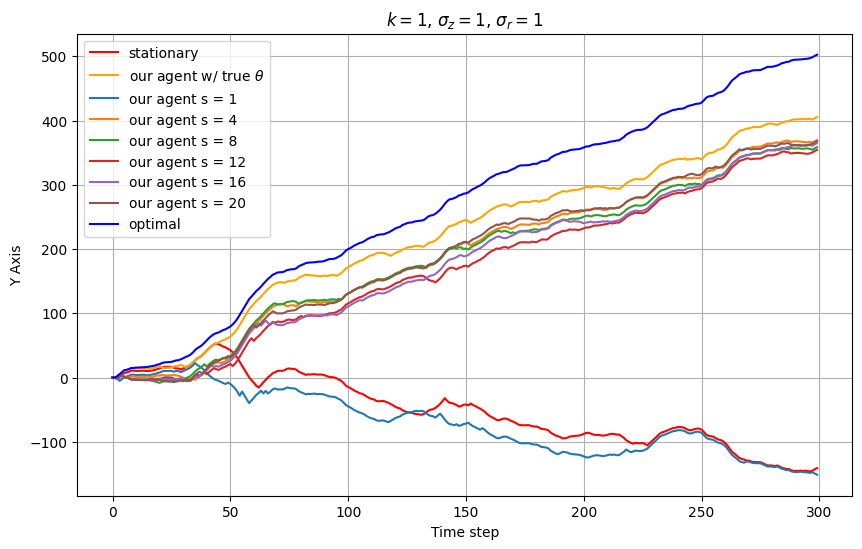

In [172]:
EXP_SEED = 99
k = 1
sigma_z = 1
sigma_r = 1
env_params = create_env_params(k, sigma_z, sigma_r)

## AGENTS ##
STAT_AGENT = StationaryAgent()
OUR_ALG_TRUE_THETA = TrueThetaAgent(lambda s, a: get_true_theta(s, a, env_params))
KALMAN_FILTER_AGENT = KalmanFilterAgent(env_params, s)
S_VALUES = [x for x in range(0, 21, 4)]
S_VALUES[0] = 1
print(S_VALUES)
AGENTS = [STAT_AGENT, OUR_ALG_TRUE_THETA, KALMAN_FILTER_AGENT] + [LatentARLinUCB(s) for s in S_VALUES]
all_actions, all_rewards, all_mean_rewards, ground_truth = run_test_simulation(env_params, AGENTS, EXP_SEED)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot([np.sum(actions_to_reward_means(all_actions[0], ground_truth)[k:t]) for t in range(NUM_TIME_STEPS)], label='stationary', color='r')
plt.plot([np.sum(actions_to_reward_means(all_actions[1], ground_truth)[k:t]) for t in range(NUM_TIME_STEPS)], label=r'our agent w/ true $\theta$', color='orange')
for i, s in enumerate(S_VALUES):
    plt.plot([np.sum(actions_to_reward_means(all_actions[3 + i], ground_truth)[k:t]) for t in range(NUM_TIME_STEPS)], label=f'our agent s = {s}')
# plt.plot([np.sum(actions_to_reward_means(all_actions[3], ground_truth)[k:t]) for t in range(NUM_TIME_STEPS)], label='kalman filter', color='g')
plt.plot([np.sum(actions_to_reward_means(ground_truth['optimal action'], ground_truth)[k:t]) for t in range(NUM_TIME_STEPS)], label='optimal', color='b')
plt.xlabel('Time step')
plt.ylabel('Y Axis')
plt.title(f'$k = {k}$, $\sigma_z = {sigma_z}$, $\sigma_r = {sigma_r}$')
plt.legend()
plt.grid()
plt.show()

### $k = 2$
---

[1, 4, 8, 12, 16, 20]


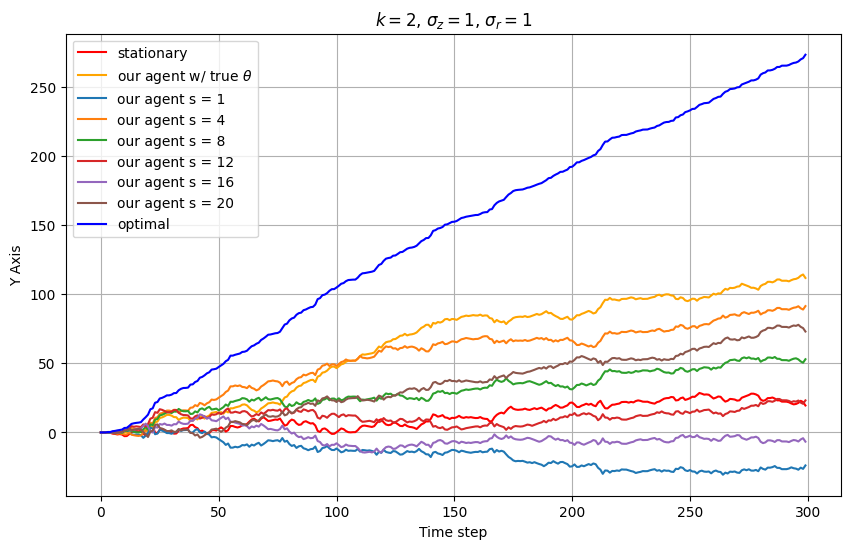

In [166]:
EXP_SEED = 99
k = 2
sigma_z = 1
sigma_r = 1
env_params = create_env_params(k, sigma_z, sigma_r)

## AGENTS ##
STAT_AGENT = StationaryAgent()
OUR_ALG_TRUE_THETA = TrueThetaAgent(lambda s, a: get_true_theta(s, a, env_params))
OUR_ALG = LatentARLinUCB(s)
KALMAN_FILTER_AGENT = KalmanFilterAgent(env_params, s)
S_VALUES = [x for x in range(0, 21, 4)]
S_VALUES[0] = 1
print(S_VALUES)
AGENTS = [STAT_AGENT, OUR_ALG_TRUE_THETA, KALMAN_FILTER_AGENT] + [LatentARLinUCB(s) for s in S_VALUES]
all_actions, all_rewards, all_mean_rewards, ground_truth = run_test_simulation(env_params, AGENTS, EXP_SEED)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot([np.sum(actions_to_reward_means(all_actions[0], ground_truth)[k:t]) for t in range(NUM_TIME_STEPS)], label='stationary', color='r')
plt.plot([np.sum(actions_to_reward_means(all_actions[1], ground_truth)[k:t]) for t in range(NUM_TIME_STEPS)], label=r'our agent w/ true $\theta$', color='orange')
for i, s in enumerate(S_VALUES):
    plt.plot([np.sum(actions_to_reward_means(all_actions[3 + i], ground_truth)[k:t]) for t in range(NUM_TIME_STEPS)], label=f'our agent s = {s}')
# plt.plot([np.sum(actions_to_reward_means(all_actions[3], ground_truth)[k:t]) for t in range(NUM_TIME_STEPS)], label='kalman filter', color='g')
plt.plot([np.sum(actions_to_reward_means(ground_truth['optimal action'], ground_truth)[k:t]) for t in range(NUM_TIME_STEPS)], label='optimal', color='b')
plt.xlabel('Time step')
plt.ylabel('Y Axis')
plt.title(f'$k = {k}$, $\sigma_z = {sigma_z}$, $\sigma_r = {sigma_r}$')
plt.legend()
plt.grid()
plt.show()

### $k = 5$
---

[1, 4, 8, 12, 16, 20]


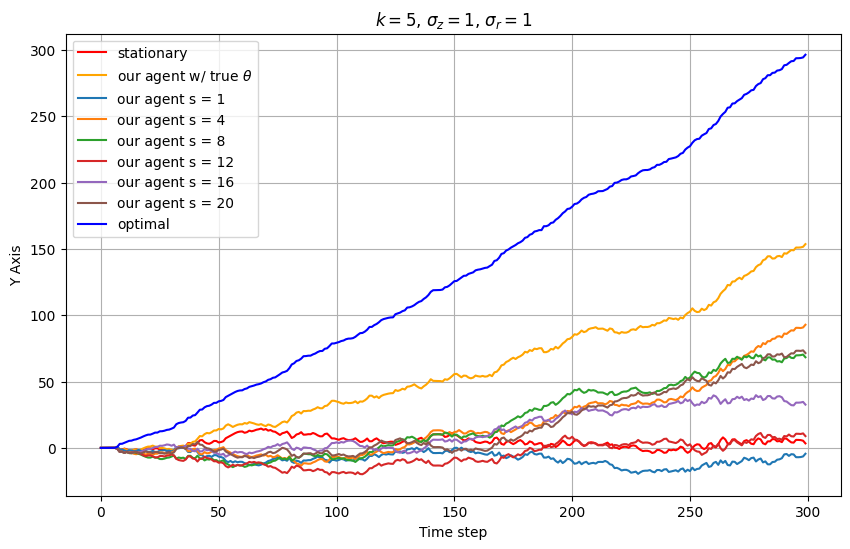

In [170]:
EXP_SEED = 99
k = 5
sigma_z = 1
sigma_r = 1
env_params = create_env_params(k, sigma_z, sigma_r)

## AGENTS ##
STAT_AGENT = StationaryAgent()
OUR_ALG_TRUE_THETA = TrueThetaAgent(lambda s, a: get_true_theta(s, a, env_params))
OUR_ALG = LatentARLinUCB(s)
KALMAN_FILTER_AGENT = KalmanFilterAgent(env_params, s)
S_VALUES = [x for x in range(0, 21, 4)]
S_VALUES[0] = 1
print(S_VALUES)
AGENTS = [STAT_AGENT, OUR_ALG_TRUE_THETA, KALMAN_FILTER_AGENT] + [LatentARLinUCB(s) for s in S_VALUES]
all_actions, all_rewards, all_mean_rewards, ground_truth = run_test_simulation(env_params, AGENTS, EXP_SEED)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot([np.sum(actions_to_reward_means(all_actions[0], ground_truth)[k:t]) for t in range(NUM_TIME_STEPS)], label='stationary', color='r')
plt.plot([np.sum(actions_to_reward_means(all_actions[1], ground_truth)[k:t]) for t in range(NUM_TIME_STEPS)], label=r'our agent w/ true $\theta$', color='orange')
for i, s in enumerate(S_VALUES):
    plt.plot([np.sum(actions_to_reward_means(all_actions[3 + i], ground_truth)[k:t]) for t in range(NUM_TIME_STEPS)], label=f'our agent s = {s}')
# plt.plot([np.sum(actions_to_reward_means(all_actions[2], ground_truth)[k:t]) for t in range(NUM_TIME_STEPS)], label='kalman filter', color='g')
plt.plot([np.sum(actions_to_reward_means(ground_truth['optimal action'], ground_truth)[k:t]) for t in range(NUM_TIME_STEPS)], label='optimal', color='b')
plt.xlabel('Time step')
plt.ylabel('Y Axis')
plt.title(f'$k = {k}$, $\sigma_z = {sigma_z}$, $\sigma_r = {sigma_r}$')
plt.legend()
plt.grid()
plt.show()

### $k = 10$
---

[1, 4, 8, 12, 16, 20]


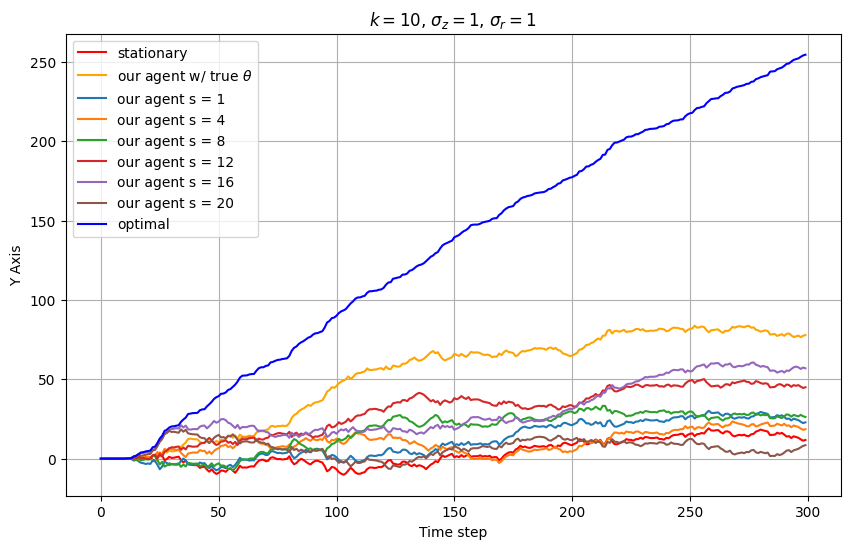

In [171]:
EXP_SEED = 99
k = 10
sigma_z = 1
sigma_r = 1
env_params = create_env_params(k, sigma_z, sigma_r)

## AGENTS ##
STAT_AGENT = StationaryAgent()
OUR_ALG_TRUE_THETA = TrueThetaAgent(lambda s, a: get_true_theta(s, a, env_params))
OUR_ALG = LatentARLinUCB(s)
KALMAN_FILTER_AGENT = KalmanFilterAgent(env_params, s)
S_VALUES = [x for x in range(0, 21, 4)]
S_VALUES[0] = 1
print(S_VALUES)
AGENTS = [STAT_AGENT, OUR_ALG_TRUE_THETA, KALMAN_FILTER_AGENT] + [LatentARLinUCB(s) for s in S_VALUES]
all_actions, all_rewards, all_mean_rewards, ground_truth = run_test_simulation(env_params, AGENTS, EXP_SEED)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot([np.sum(actions_to_reward_means(all_actions[0], ground_truth)[k:t]) for t in range(NUM_TIME_STEPS)], label='stationary', color='r')
plt.plot([np.sum(actions_to_reward_means(all_actions[1], ground_truth)[k:t]) for t in range(NUM_TIME_STEPS)], label=r'our agent w/ true $\theta$', color='orange')
for i, s in enumerate(S_VALUES):
    plt.plot([np.sum(actions_to_reward_means(all_actions[3 + i], ground_truth)[k:t]) for t in range(NUM_TIME_STEPS)], label=f'our agent s = {s}')
# plt.plot([np.sum(actions_to_reward_means(all_actions[2], ground_truth)[k:t]) for t in range(NUM_TIME_STEPS)], label='kalman filter', color='g')
plt.plot([np.sum(actions_to_reward_means(ground_truth['optimal action'], ground_truth)[k:t]) for t in range(NUM_TIME_STEPS)], label='optimal', color='b')
plt.xlabel('Time step')
plt.ylabel('Y Axis')
plt.title(f'$k = {k}$, $\sigma_z = {sigma_z}$, $\sigma_r = {sigma_r}$')
plt.legend()
plt.grid()
plt.show()

### Check Correct Actions
---

In [142]:
EXP_SEED = 99
k = 1
sigma_z = 1
sigma_r = 1
env_params = create_env_params(k, sigma_z, sigma_r)
s = 21

In [143]:
## AGENTS ##
STAT_AGENT = StationaryAgent()
OUR_ALG_TRUE_THETA = TrueThetaAgent(lambda s, a: get_true_theta(s, a, env_params))
OUR_ALG = LatentARLinUCB(s)
KALMAN_FILTER_AGENT = KalmanFilterAgent(env_params, s)
AGENTS = [STAT_AGENT, OUR_ALG_TRUE_THETA, OUR_ALG, KALMAN_FILTER_AGENT]
all_actions, all_rewards, all_mean_rewards, ground_truth = run_test_simulation(env_params, AGENTS, EXP_SEED)

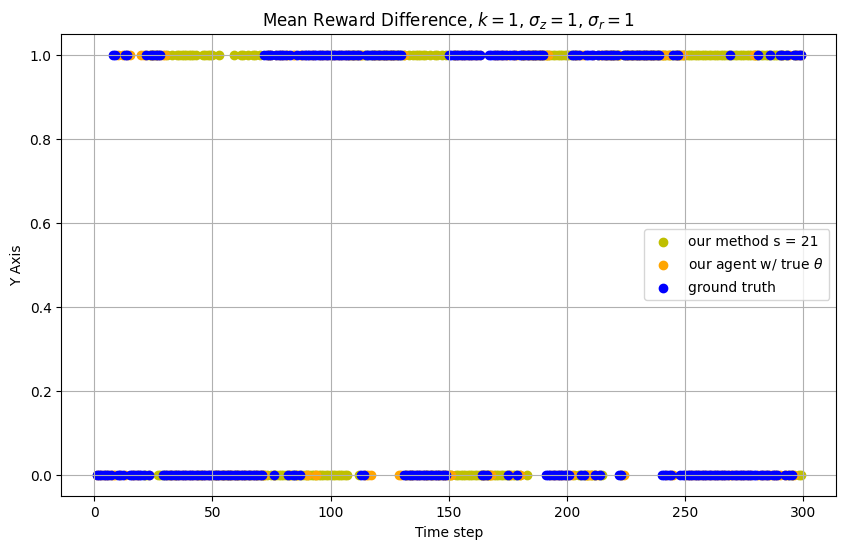

In [144]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(s, NUM_TIME_STEPS), np.array(OUR_ALG.reward_means)[:, 0] > np.array(OUR_ALG.reward_means)[:, 1], label=f'our method s = {s}', color='y')
plt.scatter(np.arange(1, NUM_TIME_STEPS), np.array(all_mean_rewards[1])[:,0] > np.array(all_mean_rewards[1])[:,1], label=r'our agent w/ true $\theta$', color='orange')
plt.scatter(np.arange(1, NUM_TIME_STEPS), np.array(ground_truth["mean reward 0"])[1:] > np.array(ground_truth["mean reward 1"])[1:], label='ground truth', color='b')
plt.xlabel('Time step')
plt.ylabel('Y Axis')
plt.title(f'Mean Reward Difference, $k = {k}$, $\sigma_z = {sigma_z}$, $\sigma_r = {sigma_r}$')
plt.legend()
plt.grid()
plt.show()

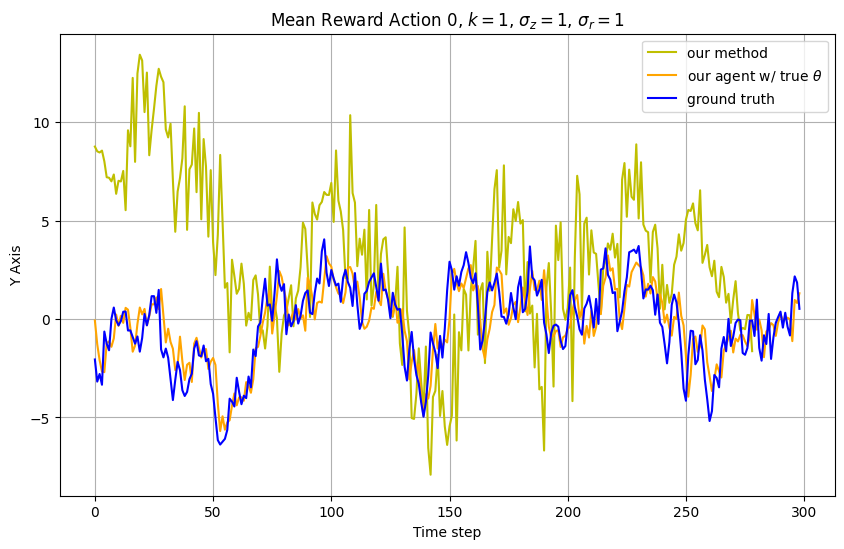

In [145]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(np.array(OUR_ALG.reward_means)[:, 0], label='our method', color='y')
plt.plot(np.array(all_mean_rewards[1])[:,0], label=r'our agent w/ true $\theta$', color='orange')
# plt.plot(np.array(all_mean_rewards[3])[1:,0], label='kalman filter', color='g')
plt.plot(np.array(ground_truth["mean reward 0"])[1:], label='ground truth', color='b')
plt.xlabel('Time step')
plt.ylabel('Y Axis')
plt.title(f'Mean Reward Action 0, $k = {k}$, $\sigma_z = {sigma_z}$, $\sigma_r = {sigma_r}$')
plt.legend()
plt.grid()
plt.show()

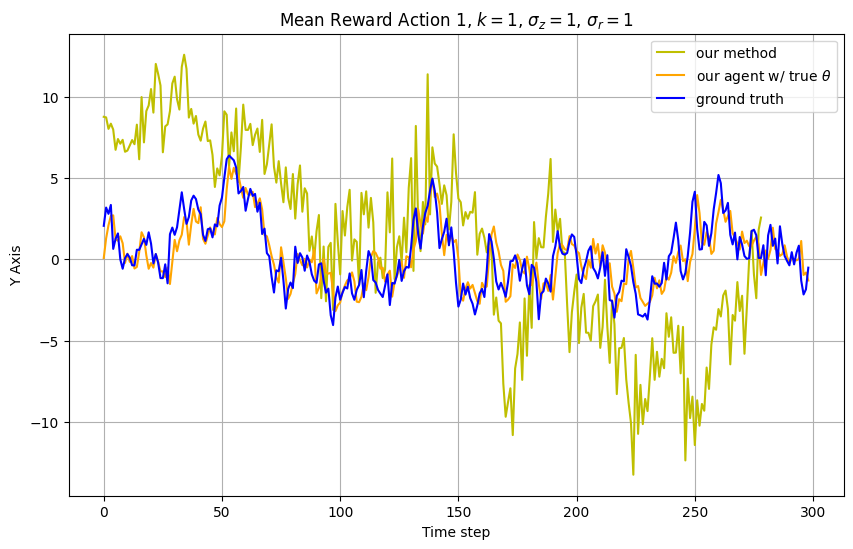

In [146]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(np.array(OUR_ALG.reward_means)[:, 1], label='our method', color='y')
plt.plot(np.array(all_mean_rewards[1])[:,1], label=r'our agent w/ true $\theta$', color='orange')
# plt.plot(np.array(all_mean_rewards[3])[1:,1], label='kalman filter', color='g')
plt.plot(np.array(ground_truth["mean reward 1"])[1:], label='ground truth', color='b')
plt.xlabel('Time step')
plt.ylabel('Y Axis')
plt.title(f'Mean Reward Action 1, $k = {k}$, $\sigma_z = {sigma_z}$, $\sigma_r = {sigma_r}$')
plt.legend()
plt.grid()
plt.show()

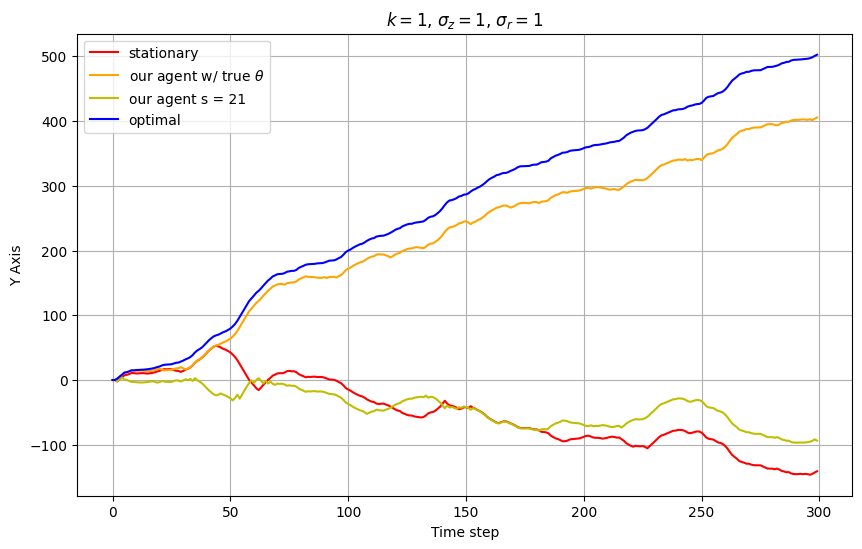

In [147]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot([np.sum(actions_to_reward_means(all_actions[0], ground_truth)[k:t]) for t in range(NUM_TIME_STEPS)], label='stationary', color='r')
plt.plot([np.sum(actions_to_reward_means(all_actions[1], ground_truth)[k:t]) for t in range(NUM_TIME_STEPS)], label=r'our agent w/ true $\theta$', color='orange')
plt.plot([np.sum(actions_to_reward_means(all_actions[2], ground_truth)[k:t]) for t in range(NUM_TIME_STEPS)], label=f'our agent s = {s}', color='y')
# plt.plot([np.sum(actions_to_reward_means(all_actions[3], ground_truth)[k:t]) for t in range(NUM_TIME_STEPS)], label='kalman filter', color='g')
plt.plot([np.sum(actions_to_reward_means(ground_truth['optimal action'], ground_truth)[k:t]) for t in range(NUM_TIME_STEPS)], label='optimal', color='b')
plt.xlabel('Time step')
plt.ylabel('Y Axis')
plt.title(f'$k = {k}$, $\sigma_z = {sigma_z}$, $\sigma_r = {sigma_r}$')
plt.legend()
plt.grid()
plt.show()

## Comparing $\tilde{r}_t(a)$

In [15]:
def process_state(s, env, actions, rewards, num_actions=2):
    bases = np.eye(num_actions).tolist()
    t = env.get_t()
    if t < s:
        return None
    else:
        recent_actions = actions[t - s:t]
        recent_rewards = rewards[t - s:t]
        X_t = np.array([reward * np.array(bases[int(action)]) for reward, action in zip(recent_rewards, recent_actions)]).flatten()
        A_t = np.array([bases[int(action)] for action in recent_actions]).flatten()
        assert len(np.concatenate([X_t, A_t, [1]])) == 2 * s * num_actions + 1
        return np.concatenate([X_t, A_t, [1]])

In [16]:
EXP_SEED = 99
k = 1
sigma_z = 1
sigma_r = 1e-3
env_params = create_env_params(k, sigma_z, sigma_r)
s = 2

In [17]:
mus = env_params["mu_a"]
betas = env_params["beta_a"]
gammas = env_params["gammas"]
gamma_0 = env_params["gamma_0"]
k = env_params["K"]
sigma_z = env_params["sigma_z"]
sigma_r = env_params["sigma_r"]
num_actions = len(mus)
Gamma, C, W, V, mu_z = create_lds_from_ar_process(gammas, gamma_0, k, sigma_z, sigma_r, betas)
P = compute_P(Gamma, C, W, V)
Kalman_Gain = compute_K(P, C, V)
c_a = compute_c_a(k, betas[0])
beta_tilde, mu_tilde = construct_beta_and_mu_tilde(s, betas, mus, c_a, num_actions, Gamma, Kalman_Gain, C)
mu_a = mus[0]

bias = compute_bias_term(k, betas[0], Gamma, Kalman_Gain, s, np.ones(k))
theta_s = [get_true_theta(s, a, env_params) for a in range(len(env_params["mu_a"]))]
print(theta_s)

[array([ 8.09997724e-07, -8.09997724e-07,  8.99999100e-01, -8.99999100e-01,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00]), array([-8.09997724e-07,  8.09997724e-07, -8.99999100e-01,  8.99999100e-01,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00])]


In [18]:
ENV = Environment(env_params, T=NUM_TIME_STEPS)
np.random.seed(EXP_SEED)
T = ENV.get_T()
K = ENV.K
betas = env_params['beta_a']
mus = env_params['mu_a']
z_tildes = np.zeros((T, K))
z_tildes[K - 1, :] = np.flip(env_params['init_zs'])
true_mean_reward = np.zeros(T)
predictions = np.zeros(T)
observations = np.zeros(T)
our_preds = np.zeros(T)
rewards = np.zeros(T)
actions = np.zeros(T)
# initializing the first K values
for _ in range(K):
    t = ENV.get_t()
    actions[t] = 1
    z_t = ENV.get_all_zs()[t]
    true_mean_reward[t] = betas[1] * z_t + mus[1]
    if t >= K:
        # steady-state
        last_z_tilde = z_tildes[t - 1]
        P = compute_P(Gamma, C, W, V)
        Kalman_Gain = compute_K(P, C, V)
        last_y = observations[t - 1]
        z_tilde = compute_z_tilde(Gamma, Kalman_Gain, C, last_z_tilde, mu_z, [last_y])
        z_tildes[t] = z_tilde
        predictions[t] = betas[1] * z_tilde[0] + mus[1]
    else:
        predictions[t] = z_tildes[t][0]
    reward = ENV.get_reward(1)
    rewards[t] = reward
    y_t = (reward - env_params['mu_a'][0]) / env_params['beta_a'][0]
    observations[t] = y_t
    ENV.increment_t()
while ENV.get_t() < T:
    ### environment ###
    t = ENV.get_t()
    ENV.state_evolution()
    z_t = ENV.get_all_zs()[t]
    ### steady-state ###
    last_z_tilde = z_tildes[t - 1]
    P = compute_P(Gamma, C, W, V)
    Kalman_Gain = compute_K(P, C, V)
    last_y = observations[t - 1]
    z_tilde = compute_z_tilde(Gamma, Kalman_Gain, C, last_z_tilde, mu_z, [last_y])
    z_tildes[t] = z_tilde
    action = t % 2
    actions[t] = action
    if t >= s:
        print(f"t: {t}, state: {state}")
        state = process_state(s, ENV, actions, rewards)
        our_preds[t] = state @ theta_s[action]
    reward = ENV.get_reward(action)
    rewards[t] = reward
    y_t = (reward - env_params['mu_a'][action]) / env_params['beta_a'][action]
    true_mean_reward[t] = betas[action] * z_t +  mus[action]
    predictions[t] = betas[action] * z_tilde[0] +  mus[action]
    observations[t] = y_t
    ### increment t ###  
    ENV.increment_t()

NameError: name 'state' is not defined

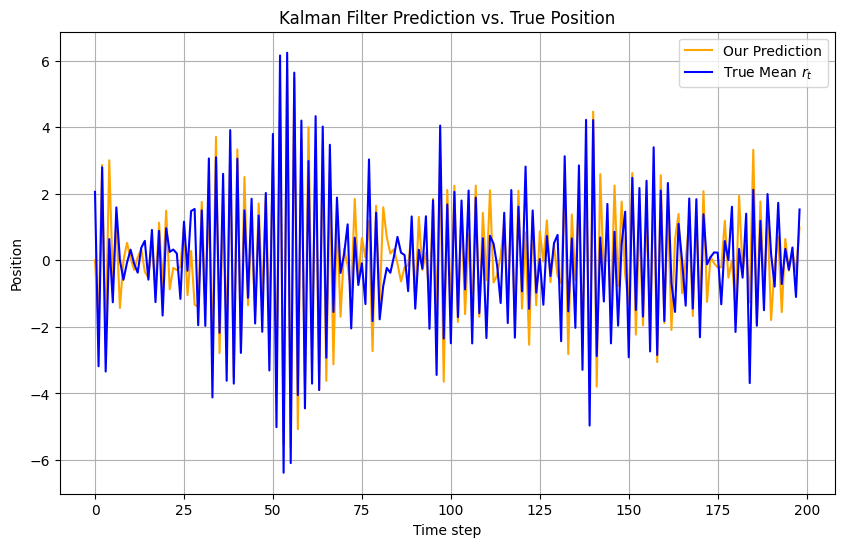

In [188]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(our_preds[k:], label="Our Prediction", color='orange')
plt.plot(true_mean_reward[k:], label='True Mean $r_t$', color='b')
# plt.plot(predictions[k:], label='Kalman Filter Prediction of Mean of $r_t$', color='g')
plt.xlabel('Time step')
plt.ylabel('Position')
plt.title('Kalman Filter Prediction vs. True Position')
plt.legend()
plt.grid()
plt.show()